## Galaxy vs quasars

- First, read the datafile.
- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

##### Food for thought
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?


In [152]:
import numpy as np
import pylab as plt

First read the file.

**Note** This file was produced with SQL query reported at https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors
 

In [153]:
data=np.genfromtxt('galaxyquasar.csv', delimiter=',',names=True,usecols=(0,1,2,3,4,6),dtype=float,comments='#')

In [154]:
names = data.dtype.names
names

('u', 'g', 'r', 'i', 'z', 'z1')

In [155]:
data=np.genfromtxt('galaxyquasar.csv', delimiter=',',skip_header=1,usecols=(0,1,2,3,4,6),dtype=float)

In [156]:
data

array([[18.97213   , 18.53676   , 18.5828    , 18.34936   , 18.29215   ,
         0.5228189 ],
       [19.24592   , 17.47646   , 16.47817   , 16.04472   , 15.68851   ,
         0.1228459 ],
       [19.43536   , 17.70268   , 16.91565   , 16.58327   , 16.39128   ,
         0.        ],
       ...,
       [18.62718   , 17.30876   , 16.87371   , 16.62399   , 16.42296   ,
         0.05442934],
       [19.5514    , 18.27711   , 17.62101   , 17.21947   , 17.03347   ,
         0.1125709 ],
       [18.80772   , 17.75751   , 17.405     , 17.2165    , 17.12295   ,
         0.04365238]])

In [157]:
d = dict(zip(names, data.T))
d

{'u': array([18.97213, 19.24592, 19.43536, ..., 18.62718, 19.5514 , 18.80772]),
 'g': array([18.53676, 17.47646, 17.70268, ..., 17.30876, 18.27711, 17.75751]),
 'r': array([18.5828 , 16.47817, 16.91565, ..., 16.87371, 17.62101, 17.405  ]),
 'i': array([18.34936, 16.04472, 16.58327, ..., 16.62399, 17.21947, 17.2165 ]),
 'z': array([18.29215, 15.68851, 16.39128, ..., 16.42296, 17.03347, 17.12295]),
 'z1': array([0.5228189 , 0.1228459 , 0.        , ..., 0.05442934, 0.1125709 ,
        0.04365238])}

In [158]:
lab=np.genfromtxt('galaxyquasar.csv', delimiter=',',skip_header=1,usecols=5,dtype=str)
lab

array(['QSO', 'GALAXY', 'GALAXY', ..., 'GALAXY', 'GALAXY', 'GALAXY'],
      dtype='<U6')

In [159]:
set(lab)

{'GALAXY', 'QSO'}

Let's build the colors

In [160]:
newclasses = ['ug', 'gr', 'ri', 'iz']

for diff in newclasses:
    d[diff]=d[diff[0]]-d[diff[1]] 
d['lab']=lab

In [161]:
d.keys()

dict_keys(['u', 'g', 'r', 'i', 'z', 'z1', 'ug', 'gr', 'ri', 'iz', 'lab'])

### Looking if there's any bimodality

Let's plot the distributions with the true labels

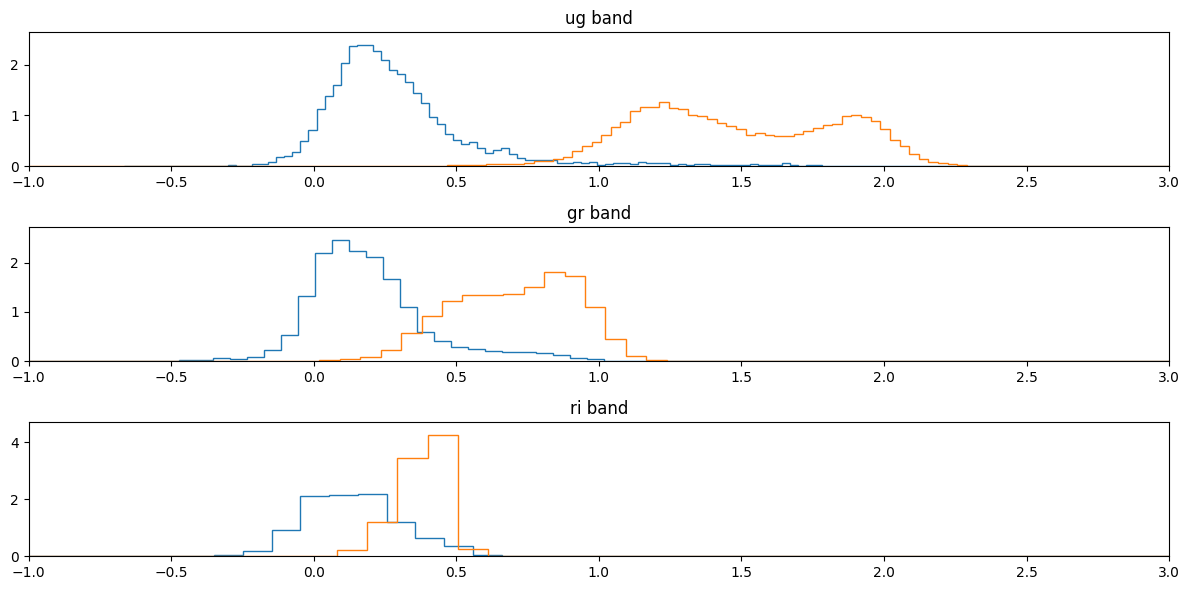

In [162]:
fig, axs = plt.subplots(3, figsize=(12,6), tight_layout = True)

for i,ax in enumerate(axs):
    ax.hist(d[newclasses[i]][lab=='QSO'], label = 'quasars', 
            histtype='step', bins=200, density=True)
    
    ax.hist(d[newclasses[i]][lab=='GALAXY'],
            histtype='step', bins=200, density=True)
    
    ax.set_title(f'{newclasses[i]} band')
    ax.set_xlim(-1,3)
    ax.margins(.1)

It looks like there are two distinct populations in the gr band for sure, in the ug band there might be even three. Our labels show which ones are galaxies and which are quasars

our labels show that this is indeed due to quasars and galaxies

In [163]:
X=np.array([d['ug'], d['gr'], d['ri'], d['iz']]).T
y = np.array(lab=='QSO',dtype=int)

Let's see what the classifiers do

In [164]:
import sklearn.model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier

In [165]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

In [166]:
X_train.shape

(33500, 4)

### Naive Bayes

This is the simplest method, we will plot the ROC curve results for the 4 different bands

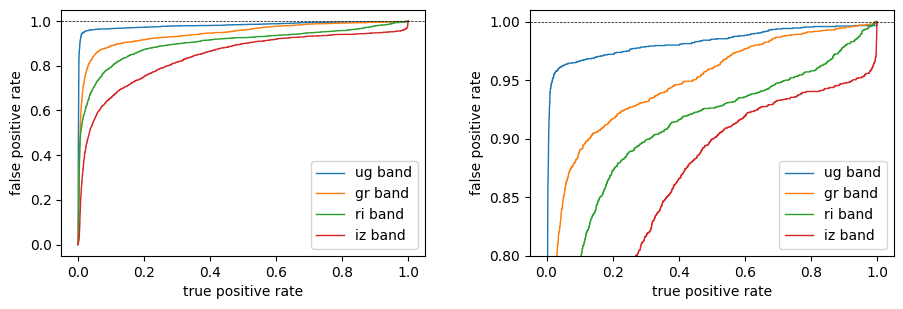

In [167]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
fig.tight_layout(pad=4.5)

clf = GaussianNB()

for i in range(4):
    
    x_i = X_train[:,i]
    x_i = x_i[:,None]
    x_i_test = X_test[:,i]
    x_i_test = x_i_test[:,None]
    
    clf.fit(x_i ,y_train)

    y_prob = clf.predict_proba(x_i_test)[:,1] #predicting on the corresponding test set 
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    
    axs[0].plot(fpr, tpr, label=f'{newclasses[i]} band', lw=1)
    
    #zooming in
    axs[1].plot(fpr, tpr, label=f'{newclasses[i]} band', lw=1)
    axs[1].set_ylim(.8,1.01)
    
    
for ax in axs:
    ax.axhline(1,0,1, ls='--', c='k' , lw=.5)
    ax.margins(.05)
    ax.legend(loc='lower right')

    ax.set_xlabel('true positive rate')
    ax.set_ylabel('false positive rate')

The most important feature for us is the one that maximizes the integral of the roc curve, because this way you are minimizing the false positive rate

In [168]:
i = 0

x_i = X_train[:,i]
x_i = x_i[:,None]
x_i_test = X_test[:,i]
x_i_test = x_i_test[:,None]

clf.fit(x_i ,y_train)

y_prob = clf.predict_proba(x_i_test)[:,1] #predicting on the corresponding test set 
fpr, tpr, thresh = roc_curve(y_test, y_prob)

In [169]:
from scipy.interpolate import interp1d
from scipy.integrate import quad

f = interp1d(fpr, tpr, 'linear')
xgrid = np.linspace(0,1,int(1e3))

In [170]:
import warnings
warnings.filterwarnings("ignore")

print(quad(f, a=0, b=1, limit=50)[0])

0.9808291085507508


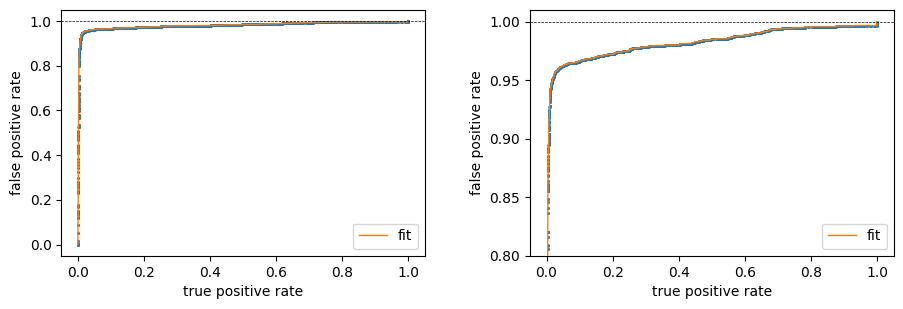

In [171]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
fig.tight_layout(pad=4.5)

axs[0].scatter(fpr, tpr, s=1)
axs[0].plot(xgrid, f(xgrid), c='C1', label='fit', lw = 1);

axs[1].scatter(fpr, tpr, s=1)
axs[1].plot(xgrid, f(xgrid), c='C1', label='fit', lw = 1)
axs[1].set_ylim(.8,1.01)


    
for ax in axs:
    ax.axhline(1,0,1, ls='--', c='k' , lw=.5)
    ax.margins(.05)
    ax.legend()
    
    ax.set_xlabel('true positive rate')
    ax.set_ylabel('false positive rate')

let's check the others

In [172]:
import warnings
warnings.filterwarnings("ignore")

In [173]:
def roc_integral(clf):
    for i in range(4):
        x_i = X_train[:,i]
        x_i = x_i[:,None]
        x_i_test = X_test[:,i]
        x_i_test = x_i_test[:,None]

        clf.fit(x_i ,y_train)

        y_prob = clf.predict_proba(x_i_test)[:,1] #predicting on the corresponding test set 
        fpr, tpr, thresh = roc_curve(y_test, y_prob)

        f = interp1d(fpr, tpr, 'linear')
        xgrid = np.linspace(0,1,int(1e3))

        print(quad(f, a=0, b=1, limit=50)[0])
        
    return 0

In [174]:
roc_integral(clf);

0.9808291085507508
0.9431465476583776
0.8995777814863399
0.8387993044793157


So it seems we were right to identify the first band as the most important feature, now let's try to use another density estimation classifier

Now let's rank the goodness of this classifier by calculating the ROC area for all features

In [176]:
x_i = X_train[:,0:4]
x_i_test = X_test[:,0:4] #all 4 features

clf.fit(x_i ,y_train)

y_prob = clf.predict_proba(x_i_test)[:,1] #predicting on the corresponding test set 
fpr, tpr, thresh = roc_curve(y_test, y_prob)

f = interp1d(fpr, tpr, 'linear')
xgrid = np.linspace(0,1,int(1e3))

print(quad(f, a=0, b=1, limit=50)[0])

0.9777487751149714


## Quadratic Discriminant Analysis

In [183]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

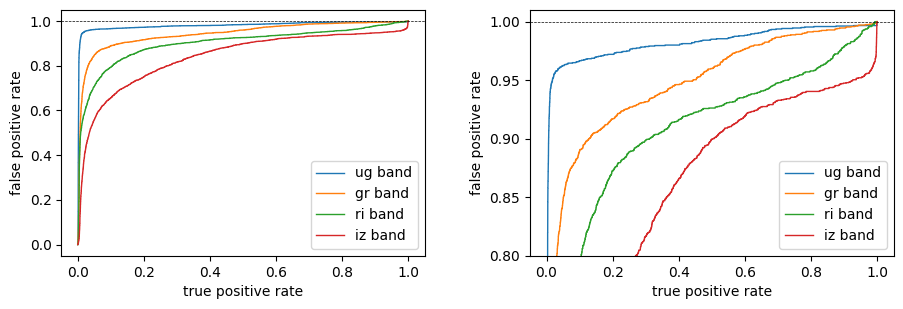

In [184]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
fig.tight_layout(pad=4.5)

clf = QuadraticDiscriminantAnalysis()

for i in range(4):
    x_i = X_train[:,i]
    x_i = x_i[:,None]
    x_i_test = X_test[:,i]
    x_i_test = x_i_test[:,None]

    clf.fit(x_i ,y_train)

    y_prob = clf.predict_proba(x_i_test)[:,1] #predicting on the corresponding test set 
    fpr, tpr, thresh = roc_curve(y_test, y_prob)

    axs[0].plot(fpr, tpr, label=f'{newclasses[i]} band', lw=1)
    
    #zooming in
    axs[1].plot(fpr, tpr, label=f'{newclasses[i]} band', lw=1)
    axs[1].set_ylim(.8,1.01)
    
    
for ax in axs:
    ax.axhline(1,0,1, ls='--', c='k' , lw=.5)
    ax.margins(.05)
    ax.legend(loc='lower right')

    ax.set_xlabel('true positive rate')
    ax.set_ylabel('false positive rate')
    
plt.legend();

In [185]:
roc_integral(clf);

0.9808291085507508
0.9431465475516895
0.8995889761330466
0.8387993044793157


Goodness of classifier

In [186]:
x_i = X_train[:,0:4]
x_i_test = X_test[:,0:4] #all 4 features

clf.fit(x_i ,y_train)

y_prob = clf.predict_proba(x_i_test)[:,1] #predicting on the corresponding test set 
fpr, tpr, thresh = roc_curve(y_test, y_prob)

f = interp1d(fpr, tpr, 'linear')
xgrid = np.linspace(0,1,int(1e3))

print(quad(f, a=0, b=1, limit=50)[0])

0.9829115770831002


## GMMBayes


In [187]:
from astroML.classification import GMMBayes

(0.9, 1.0)

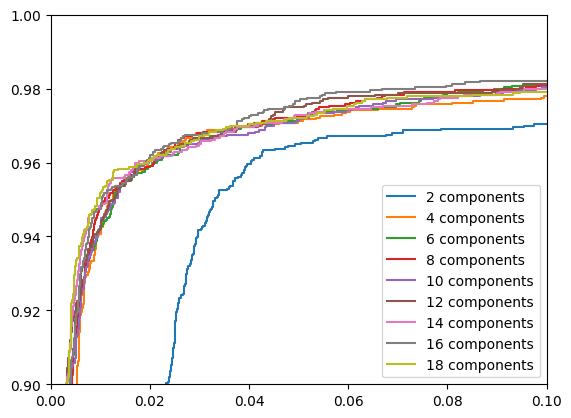

In [188]:
for n in np.arange(2,20)[::2]:
    
    clf = GMMBayes(n_components=n)
    clf.fit(X_train[:,0:4],y_train)
    
    y_prob = clf.predict_proba(X_test[:,0:4]) [:,1] 
        
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=str(n) + ' components') 
    #these are the classifier components, here i'm fitting all features together to build a stronger model

plt.legend()
plt.xlim(0,0.1)
plt.ylim(0.9,1)

4 components seems good enough

In [189]:
roc_integral(clf);

0.9849797096178007
0.9433718981152617
0.9125238636075552
0.8723092031658349


goodness of fit

In [191]:
clf = GMMBayes(n_components=4)

In [192]:
x_i = X_train[:,0:4]
x_i_test = X_test[:,0:4] #all 4 features

clf.fit(x_i ,y_train)

y_prob = clf.predict_proba(x_i_test)[:,1] #predicting on the corresponding test set 
fpr, tpr, thresh = roc_curve(y_test, y_prob)

f = interp1d(fpr, tpr, 'linear')
xgrid = np.linspace(0,1,int(1e3))

print(quad(f, a=0, b=1, limit=50)[0])

0.9892133498039272


## K Neighbors


(0.9, 1.0)

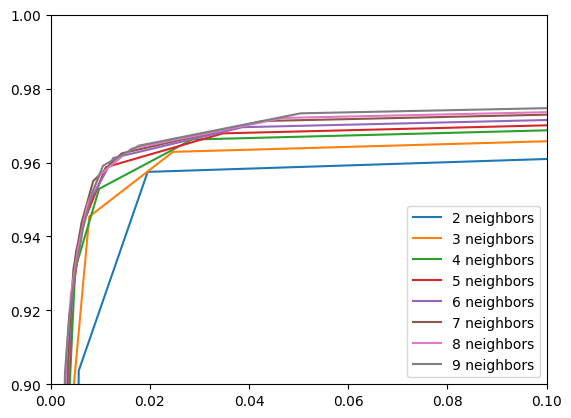

In [193]:
for n in np.arange(2,10):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X_train[:,0:4],y_train)
    
    y_prob = clf.predict_proba(X_test[:,0:4]) [:,1] 
        
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=str(n) + ' neighbors')

plt.legend()
plt.xlim(0,0.1)
plt.ylim(0.9,1)

In [194]:
roc_integral(clf);

0.9761634185149798
0.9210507319695777
0.879584575482607
0.8277260635315855


goodness of classifier

In [196]:
clf = KNeighborsClassifier(n_neighbors=9)

In [197]:
x_i = X_train[:,0:4]
x_i_test = X_test[:,0:4] #all 4 features

clf.fit(x_i ,y_train)

y_prob = clf.predict_proba(x_i_test)[:,1] #predicting on the corresponding test set 
fpr, tpr, thresh = roc_curve(y_test, y_prob)

f = interp1d(fpr, tpr, 'linear')
xgrid = np.linspace(0,1,int(1e3))

print(quad(f, a=0, b=1, limit=50)[0])

0.9844929380767738


## Conclusions

I use GMMBayes because it's the one that maximizes the ROC for the 4 components with a score of 0.989, here i can use the whole set, since i've already tested which one performs best and now i want to know just how well it manages to classify the two 

In [127]:
clf = GMMBayes(n_components=4)
clf.fit(X_train[:,0:4],y_train) #using all features for the best model
y_pred = clf.predict(X[:,0:4]) 

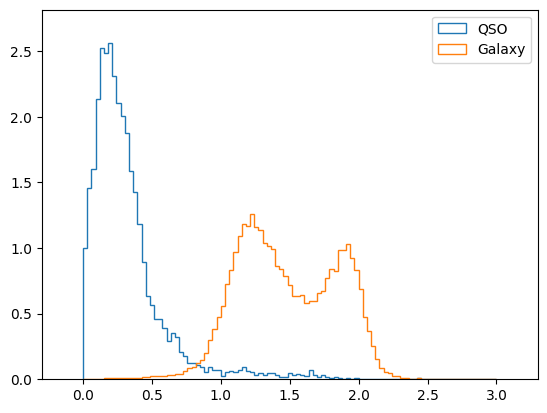

In [145]:
plt.hist(d['ug'][lab=='QSO'],histtype='step',bins=np.linspace(0,3,100), density=True, label='QSO')
plt.hist(d['ug'][lab=='GALAXY'],histtype='step',bins=np.linspace(0,3,100), density=True, label='Galaxy')
plt.margins(.1)
plt.legend();

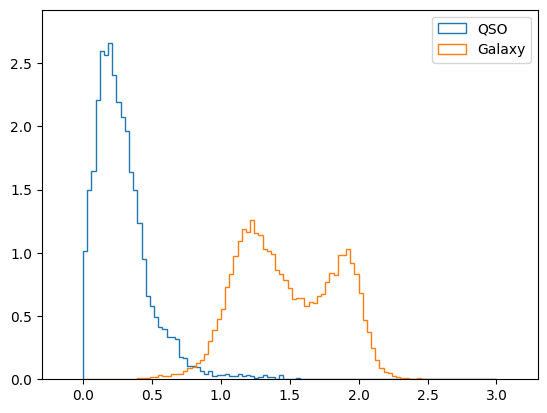

In [147]:
plt.hist(d['ug'][y_pred==1],histtype='step',bins=np.linspace(0,3,100),density=True, label='QSO')
plt.hist(d['ug'][y_pred==0],histtype='step',bins=np.linspace(0,3,100),density=True, label='Galaxy')
plt.margins(.1)
plt.legend();

Seems like GMMBayes is almost perfect but from the long tail of the quasars distribution, which is reasonable

In [150]:
import sklearn.metrics

C = sklearn.metrics.confusion_matrix(y, y_pred)
C

array([[42492,   374],
       [  528,  6606]])